In [15]:
import numpy as np 
import pandas as pd 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline


In [16]:
dataset_path = '../../data/processed/cdts_prediction.csv'
dataset = pd.read_csv(dataset_path)
dataset = dataset.drop(columns=['codigo_cliente'])

In [17]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3778 entries, 0 to 3777
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   edad                      3778 non-null   float64
 1   trabajo                   3778 non-null   object 
 2   estado_civil              3778 non-null   object 
 3   credito_en_mora           3778 non-null   object 
 4   credito_hipoteca          3778 non-null   object 
 5   credito_personal          3778 non-null   object 
 6   contacto                  3778 non-null   object 
 7   mes                       3778 non-null   object 
 8   dia_semana                3778 non-null   object 
 9   educacion                 3778 non-null   object 
 10  campania                  3778 non-null   float64
 11  dias_transcurridos        3778 non-null   float64
 12  contactos_previos         3778 non-null   float64
 13  resultado_previas         3778 non-null   object 
 14  tasa_emp

In [18]:
y = dataset['resultado']
dataset = dataset.drop(columns=['resultado'], axis=1)
dataset_ohe = pd.get_dummies(dataset, drop_first=True)
dataset_ohe.shape

(3778, 54)

In [19]:
dataset_ohe.head()

,edad,campania,dias_transcurridos,contactos_previos,tasa_empleo,indice_precios_consum,indice_confianza_consum,tasa_credito_hipotecario,personas_empleadas,trabajo_desconocido,...,educacion_basica_11anios,educacion_basica_4anios,educacion_basica_6anios,educacion_basica_9anios,educacion_basica_nueveanios,educacion_desconocido,educacion_profesional_universitario,educacion_tecnico_profesional,resultado_previas_fallo,resultado_previas_inexistente
0,29.0,3.0,3.0,2.0,-3.4,92.649,-30.1,0.714,5017.5,False,...,False,False,False,False,False,False,False,True,False,False
1,34.0,1.0,999.0,0.0,-0.1,93.200,-42.0,4.076,5195.8,False,...,False,False,False,True,False,False,False,False,False,True
2,45.0,2.0,999.0,0.0,-1.8,92.893,-46.2,1.344,5099.1,False,...,False,False,False,True,False,False,False,False,False,True
3,50.0,2.0,999.0,0.0,1.4,93.918,-42.7,4.962,5228.1,False,...,False,True,False,False,False,False,False,False,False,True
4,41.0,1.0,999.0,0.0,1.4,93.444,-36.1,4.963,5228.1,False,...,False,False,False,True,False,False,False,False,False,True


In [20]:
X = dataset_ohe

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25)

scaler = StandardScaler()

numerical_columns = dataset_ohe.select_dtypes(include='number').columns.tolist()

X_train[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])
X_test[numerical_columns]= scaler.transform(X_test[numerical_columns])


La precisión (accuracy) del modelo Random Forest es: 0.78


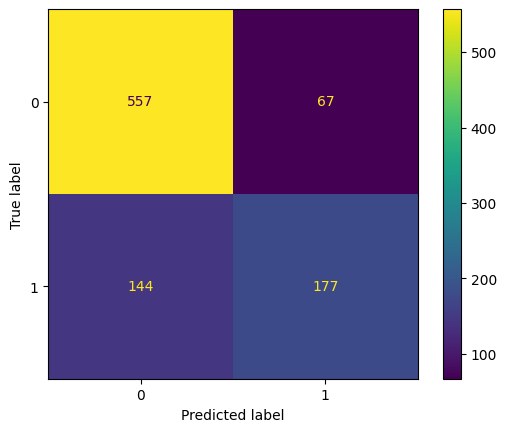

In [21]:

# Crear una instancia del clasificador de Árbol de Decisión
# random_state asegura que el resultado sea reproducible
random_forest = RandomForestClassifier(random_state=42)

# Entrenar el modelo con los datos de entrenamiento
random_forest.fit(X_train, y_train)

y_pred = random_forest.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"\nLa precisión (accuracy) del modelo Random Forest es: {accuracy:.2f}")

cm= confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [24]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestClassifier(random_state=42)) 
])

param_grid = {
    'rf__n_estimators': [100, 200, 300],         # Probaremos con 100, 200 y 300 árboles
    'rf__max_depth': [10, 20, None],              # Probaremos profundidades de 10, 20 y sin límite (None)
    'rf__max_features': ['sqrt', 'log2', 0.5]  # Probaremos la raíz cuadrada del total de features, log2 del total, y el 50% de las features
}

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    scoring='accuracy',
    verbose=2
)

# Ajustamos el grid_search a nuestros datos. ¡Este es el paso que realiza todo el trabajo!
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'rf__max_depth': [10, 20, ...], 'rf__max_features': ['sqrt', 'log2', ...], 'rf__n_estimators': [100, 200, ...]}"
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,5
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,copy,True


In [25]:
best_rf_model = grid_search.best_estimator_

In [26]:
y_pred = best_rf_model.predict(X_test)


La precisión (accuracy) del modelo Random Forest es: 0.79


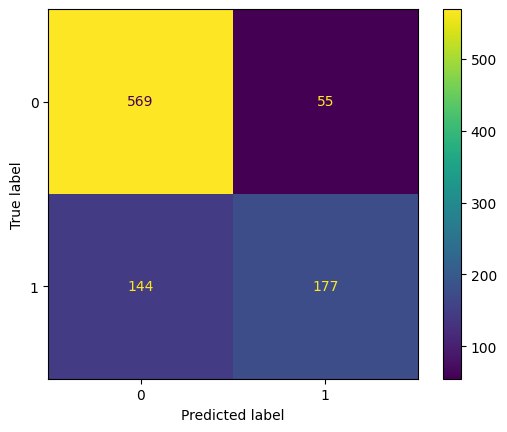

In [27]:
accuracy = accuracy_score(y_test, y_pred)
print(f"\nLa precisión (accuracy) del modelo Random Forest es: {accuracy:.2f}")

cm= confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()